In this notebook, we will try to build machine learning model that provides prediction for potential flight claims by delay/cancel.

In [1]:
# Import libraries
import pandas as pd, numpy as np, time
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, auc
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

In [2]:
# Helper functions for the notebook
def get_metrics(to_check_y, to_check_pred):
    # We check the score of set result in two ways
    # Confusion matrix
    cm = confusion_matrix(to_check_y, to_check_pred)
    # Accuracy
    accuracy=accuracy_score(to_check_pred,to_check_y)
    
    return cm, accuracy

def print_metrics(to_check_y, to_check_pred):
    cm, accuracy = get_metrics(to_check_y, to_check_pred)
    
    print("Confusion matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Delay/Cancel case accuracy:", cm[1][1] / sum(cm[1]))

# Naive approach

For the most straightforward approach, only the per-record features are used for the prediction. 

The prediction is supposed to be a regression problem, as to predict expected monetary claim of all flights. Previous study shows that there are only two is_claim values, thus the model training would be treated as classification problem first (as to make accuracy measurement easier).

In [3]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data.csv')

# Check data columns
data_df.columns

Index(['flight_id', 'flight_no', 'Week', 'Departure', 'Arrival', 'Airline',
       'std_hour', 'delay_time', 'flight_date', 'is_claim'],
      dtype='object')

We first modify the columns for model training:

In [4]:
# Transform categorical features to numerical labels such that the ML model can utilize those features properly
cat_feats = ['flight_no', 'Week', 'Departure','Arrival','Airline','std_hour']
for cat_col in cat_feats:
    data_df[cat_col] = data_df[cat_col].astype("category").cat.codes + 1

In [5]:
# For target is_claim, since we know there are only two values, the plan is to transform it into boolean variable
# It is easier for measuring accuracy in this way. In the actual model, we can ignore this part and do regression on is_claim amount instead.
def set_is_claim(val):
    if val == 0:
        return 0
    else:
        return 1
data_df['is_claim_bool'] = data_df["is_claim"].apply(set_is_claim)

In [6]:
# Check transformed result
data_df.sample(10)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,is_claim_bool
86736,268924,1787,36,1,118,72,16,0.7,2015-09-09,0,0
21476,65893,1526,20,1,142,54,8,0.3,2016-05-14,0,0
510856,1589807,1569,17,1,76,54,12,0.3,2016-04-25,0,0
795698,2471559,1437,14,1,115,54,9,0.4,2016-04-03,0,0
494764,1539197,1231,40,1,142,47,23,0.3,2015-10-02,0,0
88122,273333,1083,26,1,21,40,18,1.1,2014-06-25,0,0
765641,2378615,1520,37,1,142,54,14,-0.1,2013-09-15,0,0
691696,2149833,1145,5,1,36,47,19,0.3,2015-01-30,0,0
762045,2367320,880,35,1,129,28,15,0.4,2015-09-01,0,0
422655,1314670,322,52,1,142,24,20,0.4,2015-12-24,0,0


In [7]:
# Get x/y columns
x_all = data_df[cat_feats]
y_all = data_df['is_claim_bool']

# Split training/testing set
# Fixed random state for testing
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

There are several machine learning models that can tackle this problem. It is decided to use boosting (i.e. GBDT in particular) as it is relatively easier to tune for (in contrast to something like NN models that requires tuning network structure), and the underlying decision tree makes it easier to interpret for feature importance.

In [8]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
d_train = lgb.Dataset(train, label=y_train)
params = {
    "objective": "binary",
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model_naive = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


The predicted is_claim_bool is then done by the model, and simply rounded as 0/1 for accuracy measurement.

In [9]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model_naive.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[600585   1433]
 [ 20284   7077]]
Accuracy: 0.9654945589223664
Delay/Cancel case accuracy: 0.2586528270165564


In [10]:
# Show Q1/Q2 error of classification-based model
# It is simply done by multiplying true negative/false positive result by claim amount
cm, _ = get_metrics(to_check_y, to_check_pred)

# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 27.604352862106936
Q2 error: 22083.482289685548


In [11]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = model_naive.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[256283   1400]
 [  9948   2104]]
Accuracy: 0.9579290785400486
Delay/Cancel case accuracy: 0.1745768337205443


In [12]:
cm, _ = get_metrics(to_check_y, to_check_pred)
# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 33.65673716796115
Q2 error: 26925.389734368917


Although the model shows a 95% accuracy, the confusion matrix shows that there are many cases of actual needed-to-be-claimed flights, but mis-classified as normal flights. The classified ratio of delay/cancel flights in this case would be ~20%.

In [13]:
# Show feature importance of the approach
pd.DataFrame({'feature': cat_feats, 
              'Importance by split': model_naive.feature_importance(importance_type='split'), 
              'Importance by gain': model_naive.feature_importance(importance_type='gain')}).sort_values('Importance by gain', ascending=False)

,Importance by gain,Importance by split,feature
0,278330.314783,81033,flight_no
1,124201.575907,92665,Week
3,74581.110716,13772,Arrival
5,48224.152483,61363,std_hour
4,32982.177831,7511,Airline
2,0.000000,0,Departure


Train with regressor instead of classifier:

In [14]:
# Get x/y columns
x_all = data_df[cat_feats]
y_all = data_df['is_claim']

# Split training/testing set
# Fixed random state for testing
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

In [15]:
d_train = lgb.Dataset(train, label=y_train)
params = {
    "objective": "regression",
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model_naive_regressor = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [16]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model_naive_regressor.predict(to_check_train)

In [17]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

Q1 error: 44.23232618822946
Q2 error: 16876.900381111376


In [18]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = model_naive_regressor.predict(to_check_train)

In [19]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

Q1 error: 53.12546476009254
Q2 error: 23500.60364152895


# Feature engineering approach

In feature engineering approach, lagged statistics are added in different perspectives per different time bins. The model would suppose to make better decision from the extra features.

In [20]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data_transformed.csv')

# Check data size
data_df.columns

Index(['Unnamed: 0', 'flight_id', 'flight_no', 'Week', 'Departure', 'Arrival',
       'Airline', 'std_hour', 'delay_time', 'flight_date',
       ...
       'air_2_day_cancel_count', 'air_4_day_cancel_count',
       'air_wk_cancel_count', 'arr_air_hr_cancel_count',
       'arr_air_2_hr_cancel_count', 'arr_air_4_hr_cancel_count',
       'arr_air_day_cancel_count', 'arr_air_2_day_cancel_count',
       'arr_air_4_day_cancel_count', 'arr_air_wk_cancel_count'],
      dtype='object', length=139)

In [21]:
# Transform categorical features to numerical labels such that the ML model can utilize those features properly
delay_time_and_count_feats = [col_str for col_str in list(data_df.columns) if col_str.endswith('_count') or col_str.endswith('_delay_time')]
cat_feats = ['flight_no', 'Week', 'Departure','Arrival','Airline','std_hour']
all_feats = cat_feats + delay_time_and_count_feats
for cat_col in cat_feats:
    data_df[cat_col] = data_df[cat_col].astype("category").cat.codes + 1

In [22]:
# For target is_claim, since we know there are only two values, the plan is to transform it into boolean variable
# It is easier for measuring accuracy in this way. In the actual model, we can ignore this part and do regression on is_claim amount instead.
def set_is_claim(val):
    if val == 0:
        return 0
    else:
        return 1
data_df['is_claim_bool'] = data_df["is_claim"].apply(set_is_claim)

In [23]:
# Check transformed result
data_df.sample(10)

,Unnamed: 0,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,...,air_4_day_cancel_count,air_wk_cancel_count,arr_air_hr_cancel_count,arr_air_2_hr_cancel_count,arr_air_4_hr_cancel_count,arr_air_day_cancel_count,arr_air_2_day_cancel_count,arr_air_4_day_cancel_count,arr_air_wk_cancel_count,is_claim_bool
568741,568741,1769704,908,31,1,160,30,11,0.8,2015-08-05,...,7.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
717631,717631,2230194,896,4,1,132,30,16,-7.6,2015-01-28,...,20.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
314059,314059,977953,2061,9,1,41,103,16,-0.1,2015-03-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
118943,118943,368862,918,12,1,84,30,17,0.0,2014-03-19,...,11.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
896912,896912,2786548,152,19,1,159,12,20,0.4,2015-05-07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
592343,592343,1842531,151,17,1,69,12,24,0.3,2015-04-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
52692,52692,163292,359,39,1,112,28,13,0.3,2013-09-24,...,25.0,26.0,0.0,0.0,0.0,5.0,11.0,11.0,11.0,0
863081,863081,2681557,1917,10,1,62,85,22,0.7,2016-03-04,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
291212,291212,905533,748,2,1,25,30,21,0.8,2016-01-13,...,31.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
559608,559608,1741164,928,14,1,95,30,8,0.2,2015-04-08,...,10.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [24]:
# Get x/y columns
x_all = data_df[all_feats]
y_all = data_df['is_claim_bool']

# Split training/testing set
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

In [25]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
d_train = lgb.Dataset(train, label=y_train)
params = {
    "objective": "binary",
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Accuracy measurement from feature engineering approach:

In [26]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[602005     13]
 [    17  27344]]
Accuracy: 0.9999523339672916
Delay/Cancel case accuracy: 0.9993786776799094


In [27]:
cm, _ = get_metrics(to_check_y, to_check_pred)
# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 0.038132826166745314
Q2 error: 30.506260933396252


In [28]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = abs(model.predict(to_check_train).round())
print_metrics(to_check_y, to_check_pred)

Confusion matrix:
[[256957    726]
 [  6974   5078]]
Accuracy: 0.9714534635846294
Delay/Cancel case accuracy: 0.42134085628941254


In [29]:
cm, _ = get_metrics(to_check_y, to_check_pred)
# Q1 error
print("Q1 error:", (cm[0][1] + cm[1][0]) * 800 / len(to_check_y))
# Q2 error
print("Q2 error:", (cm[0][1] + cm[1][0]) * (800 ** 2) / len(to_check_y))

Q1 error: 22.837229132296514
Q2 error: 18269.78330583721


In [30]:
# Copy testing set for later cells
roc_to_check_train = to_check_train.copy()
roc_to_check_y = to_check_y.copy()

The result shows that the model fits well on the training set. However, testing set shows quite a drop in accuracy, especially upon delay/cancel case. Nonetheless, the model now achieves ~42% accuracy on delay/cancel case as opposed to ~20% in the naive approach.

The feature importance is as below:

In [31]:
pd.DataFrame({'feature': all_feats, 
              'Importance by split': model.feature_importance(importance_type='split'), 
              'Importance by gain': model.feature_importance(importance_type='gain')}).sort_values('Importance by split', ascending=False)

,Importance by gain,Importance by split,feature
0,213657.321129,18707,flight_no
6,30161.040394,9569,dep_hr_delay_time
16,20586.648163,9117,arr_day_delay_time
30,42074.427428,8505,arr_air_day_delay_time
7,20677.913769,8118,dep_2_hr_delay_time
15,20127.372806,7492,arr_4_hr_delay_time
8,25144.365564,7361,dep_4_hr_delay_time
65,15020.037102,7073,dep_day_cancel_count
1,51570.884256,6766,Week
14,38487.621168,6510,arr_2_hr_delay_time


In [32]:
pd.DataFrame({'feature': all_feats, 
              'Importance by split': model.feature_importance(importance_type='split'), 
              'Importance by gain': model.feature_importance(importance_type='gain')}).sort_values('Importance by gain', ascending=False)

,Importance by gain,Importance by split,feature
0,213657.321129,18707,flight_no
89,110350.546217,1532,arr_air_wk_cancel_count
1,51570.884256,6766,Week
32,44337.837463,5121,arr_air_4_day_delay_time
30,42074.427428,8505,arr_air_day_delay_time
14,38487.621168,6510,arr_2_hr_delay_time
6,30161.040394,9569,dep_hr_delay_time
3,27989.829101,2264,Arrival
8,25144.365564,7361,dep_4_hr_delay_time
31,23818.623223,6209,arr_air_2_day_delay_time


Train with regressor instead of classifier:

In [33]:
# Get x/y columns
x_all = data_df[all_feats]
y_all = data_df['is_claim']

# Split training/testing set
# Fixed random state for testing
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

In [34]:
d_train = lgb.Dataset(train, label=y_train)
params = {
    "objective": "regression",
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model_feat_eng_regressor = lgb.train(params, d_train, categorical_feature = cat_feats)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [35]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model_feat_eng_regressor.predict(to_check_train)

In [36]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

Q1 error: 16.079132785284454
Q2 error: 1596.351163125319


In [37]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = model_feat_eng_regressor.predict(to_check_train)

In [38]:
# Q1 error
print("Q1 error:", sum(abs(to_check_pred - to_check_y)) / len(to_check_y))

# Q2 error
print("Q2 error:", sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y))

Q1 error: 44.56227772790395
Q2 error: 15463.127189489567


## Further inspection on model performance

In [39]:
# Use raw values in below inspection
to_check_train = roc_to_check_train
to_check_y = roc_to_check_y
to_check_pred_raw = model.predict(to_check_train)

<Figure size 432x288 with 0 Axes>

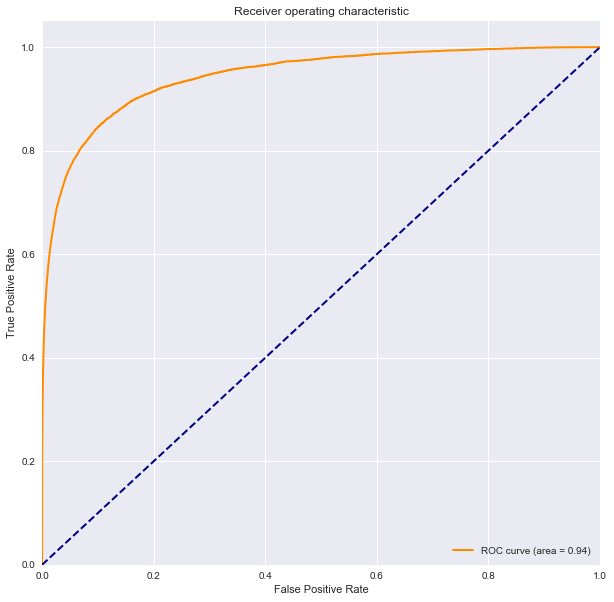

In [40]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(to_check_y, to_check_pred_raw)
roc_auc = auc(fpr,tpr)
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Although the ROC graph shows an AUC of 0.91, that should bear in mind that the given dataset is highly skewed to positive labels (i.e. flight is not claimed). The "residual" appearance of flight claim case is insignificant from this graph.

Plotting the prediction distribution of the two labels (is_claim_bool = 0/1) shows a better truth in this case:

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

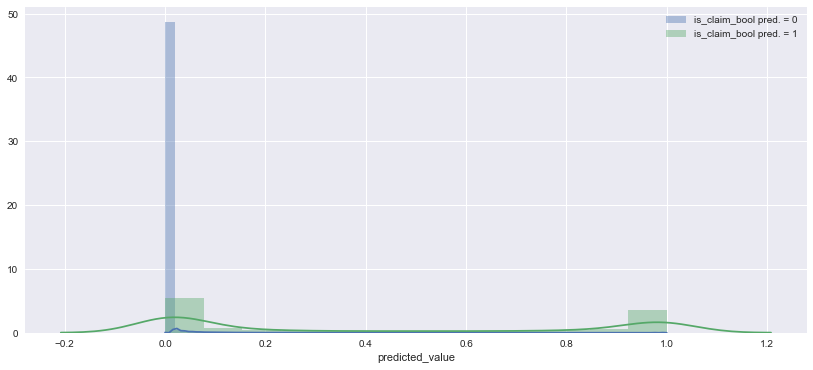

In [41]:
prob_df = pd.DataFrame({'predicted_value': to_check_pred_raw, 'true_value': to_check_y})
plt.figure()
plt.figure(figsize=(14,6))
sns.distplot(prob_df[prob_df['true_value'] == 0]['predicted_value'], label='is_claim_bool pred. = 0')
sns.distplot(prob_df[prob_df['true_value'] == 1]['predicted_value'], label='is_claim_bool pred. = 1')
plt.legend()

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

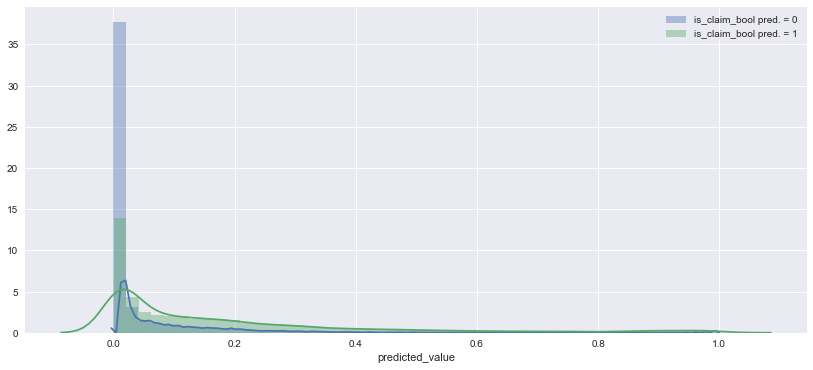

In [42]:
# Compare with naive approach 
to_check_pred_raw = model_naive.predict(to_check_train)
prob_df = pd.DataFrame({'predicted_value': to_check_pred_raw, 'true_value': to_check_y})
plt.figure()
plt.figure(figsize=(14,6))
sns.distplot(prob_df[prob_df['true_value'] == 0]['predicted_value'], label='is_claim_bool pred. = 0')
sns.distplot(prob_df[prob_df['true_value'] == 1]['predicted_value'], label='is_claim_bool pred. = 1')
plt.legend()

It is shown that the model is good at predicting is_claim_bool = 0 case, whereas is_claim_bool = 1 case would be hard, as the predicted value spreaded across [0, 1]. But from the graph, we can find a tradeoff between true-negative and false-positive by selecting a optimal threshold for predicting is_claim_bool as 1 (previously we just rounded off the prediction value).

In [43]:
# Attempt to select appropriate cutoff for prob
# Record false positive and true negative rates
fpr = []
tnr = []

for i in range(20):
    ratio = i / 20

    # custom function
    def pred_by_cutoff(x):
        return 1 if x > ratio else 0

    # define vectorized sigmoid
    pred_by_cutoff_v = np.vectorize(pred_by_cutoff)

    # test
    cm, _ = get_metrics(to_check_y, pred_by_cutoff_v(to_check_pred_raw))
    fp = cm[1][0]
    tn = cm[0][1]
    print("Ratio:", ratio, "Wrong:", fp+tn)
    print_metrics(to_check_y, pred_by_cutoff_v(to_check_pred_raw))
    fpr.append(fp)
    tnr.append(tn)

Ratio: 0.0 Wrong: 257683
Confusion matrix:
[[     0 257683]
 [     0  12052]]
Accuracy: 0.04468089050364246
Delay/Cancel case accuracy: 1.0
Ratio: 0.05 Wrong: 48875
Confusion matrix:
[[213635  44048]
 [  4827   7225]]
Accuracy: 0.8188036406102286
Delay/Cancel case accuracy: 0.5994855625622303
Ratio: 0.1 Wrong: 35315
Confusion matrix:
[[228524  29159]
 [  6156   5896]]
Accuracy: 0.8690752034404138
Delay/Cancel case accuracy: 0.48921340856289414
Ratio: 0.15 Wrong: 27208
Confusion matrix:
[[237736  19947]
 [  7261   4791]]
Accuracy: 0.8991306282091682
Delay/Cancel case accuracy: 0.3975273813474942
Ratio: 0.2 Wrong: 21306
Confusion matrix:
[[244631  13052]
 [  8254   3798]]
Accuracy: 0.9210113630044303
Delay/Cancel case accuracy: 0.3151344175240624
Ratio: 0.25 Wrong: 17729
Confusion matrix:
[[248909   8774]
 [  8955   3097]]
Accuracy: 0.934272526739207
Delay/Cancel case accuracy: 0.2569697975439761
Ratio: 0.3 Wrong: 15608
Confusion matrix:
[[251599   6084]
 [  9524   2528]]
Accuracy: 0.942

<Figure size 432x288 with 0 Axes>

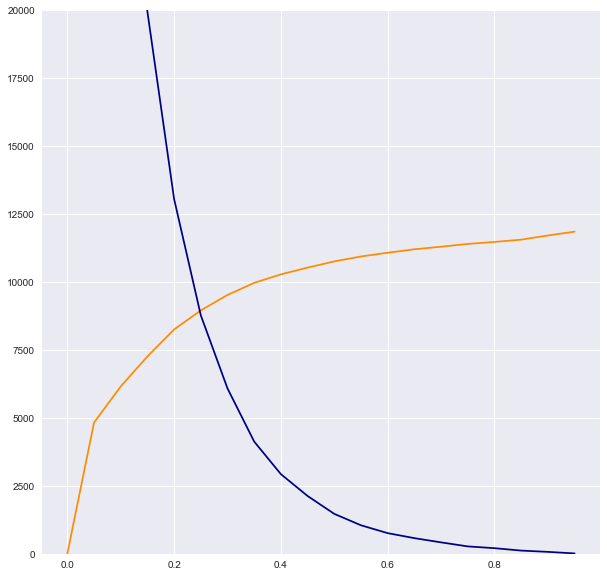

In [44]:
prob_bins = [i / 20 for i in range(20)]
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(prob_bins, fpr, color='darkorange')
plt.plot(prob_bins, tnr, color='navy')
plt.ylim([0, 20000])
plt.show()

If we select the threshold ~= 0.3 for classifying flight claim, the delay/cancel case accuracy could be boosted to 0.614 in exchange of more true negatives.

Test with 10-fold to see if model training is stable (too slow for my computer ...):

In [32]:
for i in range(10):
    train, test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3)
    
    d_train = lgb.Dataset(train, label=y_train)
    params = {
        "objective": "binary",
        "max_depth": 50,
        "learning_rate" : 0.1, 
        #"num_leaves": 1200,
        "num_leaves": 900, 
        #"num_leaves": 300,
        #"num_leaves": 3000,
        "n_estimators": 300
    }
    model = lgb.train(params, d_train, categorical_feature = cat_feats)
    
    print("Round ", i, "---------------------")
    # Testing set metrics
    to_check_train, to_check_y = test, y_test
    to_check_pred = model.predict(to_check_train).round()
    print_metrics(to_check_y, to_check_pred)

D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Round  0 ---------------------
Confusion matrix:
[[257343    691]
 [  6735   4966]]
Accuracy: 0.9724692753999296
Delay/Cancel case accuracy: 0.4244081702418597


D:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


KeyboardInterrupt: 